<a href="https://colab.research.google.com/github/my000own000files1/Fuzzy/blob/main/lab3_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

система:
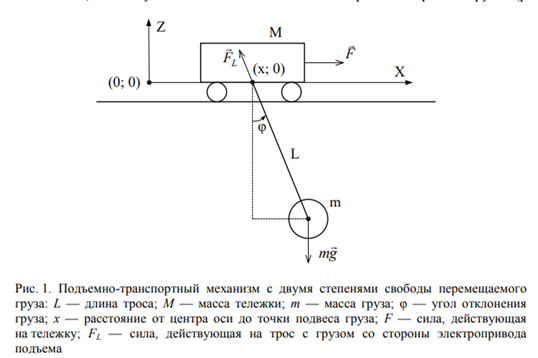


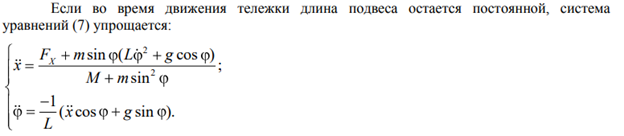

In [93]:
!pip install -U scikit-fuzzy

Requirement already up-to-date: scikit-fuzzy in /usr/local/lib/python3.7/dist-packages (0.4.2)


In [94]:
  !pip install -U control

Requirement already up-to-date: control in /usr/local/lib/python3.7/dist-packages (0.9.0)


In [104]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import control as ct
from control.matlab import * #I want to have a MATLAB-like environment
import matplotlib.pyplot as plt
import math

In [106]:
#creating object dynamics
def port_crane_updfcn(t,s,u,params):
  """A port crane with a cargo on a rope dynamics (like object) 
  assumptions: by all perturbations such as the rolling friction
   force at the point of contact with the rails, air resistance,
    we also assume that the cable is inextensible, i.e. L=const

  Parameters
  ----------
  x: array 
      System state: [x,dx,phi,dphi], where x is a port crane (object) position
      in [0,200] [m], dx is velocity of the port crane in m/s, phi is an angle
      of deflection of the rope with a container, which is a cargo and attached
      to the end of the rope in rad, dphi is angular velocity of the rope 
      deflection in rad/sec

  u: array
      System inputs: [Fx], where Fx is a pulling force exerted on the
      trolley, created by electric motor in Newton

  Returns 
  -------
  float
      [ddx,ddphi], where ddx is a port crane acceleration in m/s^2 and ddphi is 
      angular acceleration in rad/s^2
  """
  from math import sin,cos

  # Set up the system parameters
  m = params.get('m', 4000.)  # cargo mass in kg
  M = params.get('M', 10000.) # port crane mass in kg
  g = params.get('g', 9.8)    # gravitational constant, m/s^2
  L = params.get('L', 30)     # length of the drope in m
  

  # Define variables for object state
  r = s[0]    # port crane position in m
  dx = s[1]   # velocity of the port crane in m/s
  phi = s[2]  # deflection of the rope angle in rad
  dphi = s[3] # angular velocity of the rope deflection in rad/sec

  #Define variables for object inputs
  Fx = u[0]   # pulling force exerted on the trolley in Newtons

  # calculating the output variables
  ddx = ((Fx + m*sin(phi))*(L*dphi**2+g*cos(phi)))/(M + m*(sin(phi))**2)
  ddphi = (-1/L)*(((Fx + m*sin(phi))*(L*dphi**2+g*cos(phi)))/(M + m*(sin(phi))**2)*cos(phi) + g*sin(phi))

  return np.array([dx,ddx,dphi,ddphi])

def port_crane_outfcn(t, s, u, params):
  return s[0:3]

In [234]:
# Define a generator for creating a plots
def system_dynamic_plot(sys, t, y, u, t_start_input=0, x_ref=0, linetype='b-',
                         subplots=[None, None, None],fig_size=None):
  #Figure out the plot bounds and indices
  x_min = 0; x_max = x_ref+math.ceil(x_ref*0.05); x_ind = sys.find_state('x')
  phi_min = -math.pi/18; phi_max = math.pi/18; phi_ind = sys.find_state('phi')
  Fx_min = 0; Fx_max = max(u); Fx_ind = sys.find_input('Fx') 

  #convert phi from rad to deg
  from math import pi 
  y[phi_ind]*=180/pi

  # Make sure the upper and lower bounds on x are OK
  while max(y[x_ind]) > x_max: x_max += 1
  while min(y[x_ind]) < x_min: x_min -= 1

  # Make sure the upper and lower bounds on phi are OK
  while max(y[phi_ind]) > phi_max: phi_max += 1
  while min(y[phi_ind]) < phi_min: phi_min -= 1
  phi_max+=1
  phi_min-=1

  # Make sure the upper and lower bounds on Fx are OK
  if len(u.shape)>1:
    while max(u[Fx_ind]) > Fx_max: Fx_max += 1
    while min(u[Fx_ind]) < Fx_min: Fx_min -= 1
  else:
    while max(u) > Fx_max: Fx_max += 1
    while min(u) < Fx_min: Fx_min -= 1
  Fx_max += Fx_max*0.1

  # Create arrays for return values
  subplot_axes = subplots.copy()

  # Position profile
  if subplot_axes[0] is None:
    subplot_axes[0] = plt.subplot(3,1,1)
  else:
    plt.sca(subplots[0])
  plt.plot(t, y[x_ind], linetype)
  plt.plot(t, x_ref*np.ones(t.shape), 'k-')
  plt.plot([t_start_input, t_start_input], [x_min, x_max], 'k--')
  plt.axis([0, t[-1], x_min, x_max])
  plt.xlabel('Time $t$ [s]')
  plt.ylabel('Port crane \nposition $x$')
  plt.grid(color='0.5')
  
  # Angle phi profile
  if subplot_axes[1] is None:
    subplot_axes[1] = plt.subplot(3,1,2)
  else:
    plt.sca(subplots[1])
  plt.plot(t, y[phi_ind], linetype)
  plt.plot([t_start_input, t_start_input], [phi_min, phi_max], 'k--')
  plt.axis([0, t[-1], phi_min, phi_max])
  plt.xlabel('Time $t$ [s]')
  plt.ylabel('deflection of the\n rope angle\n $\phi$ in $\circ$')
  plt.grid(color='0.5')

  # Pulling force
  if subplot_axes[2] is None:
    subplot_axes[2] = plt.subplot(3,1,3)
  else:
    plt.sca(subplots[2])
  if len(u.shape)>1:
    plt.plot(t, u[Fx_ind], linetype)
  else:
    plt.plot(t, u, linetype)
  plt.plot([t_start_input, t_start_input], [Fx_min, Fx_max], 'k--')
  plt.axis([0, t[-1], Fx_min, Fx_max])
  plt.xlabel('Time $t$ [s]')
  plt.ylabel('pulling force Fx,\n $Newton$')
  plt.grid(color='0.5')
  
  return subplot_axes

In [170]:
#Input/ouput model for the object
sys_object = ct.NonlinearIOSystem(port_crane_updfcn, port_crane_outfcn, 
                   inputs = ('Fx'), outputs = None, states=('x','dx','phi','dphi'),
                   name='sys_object',)

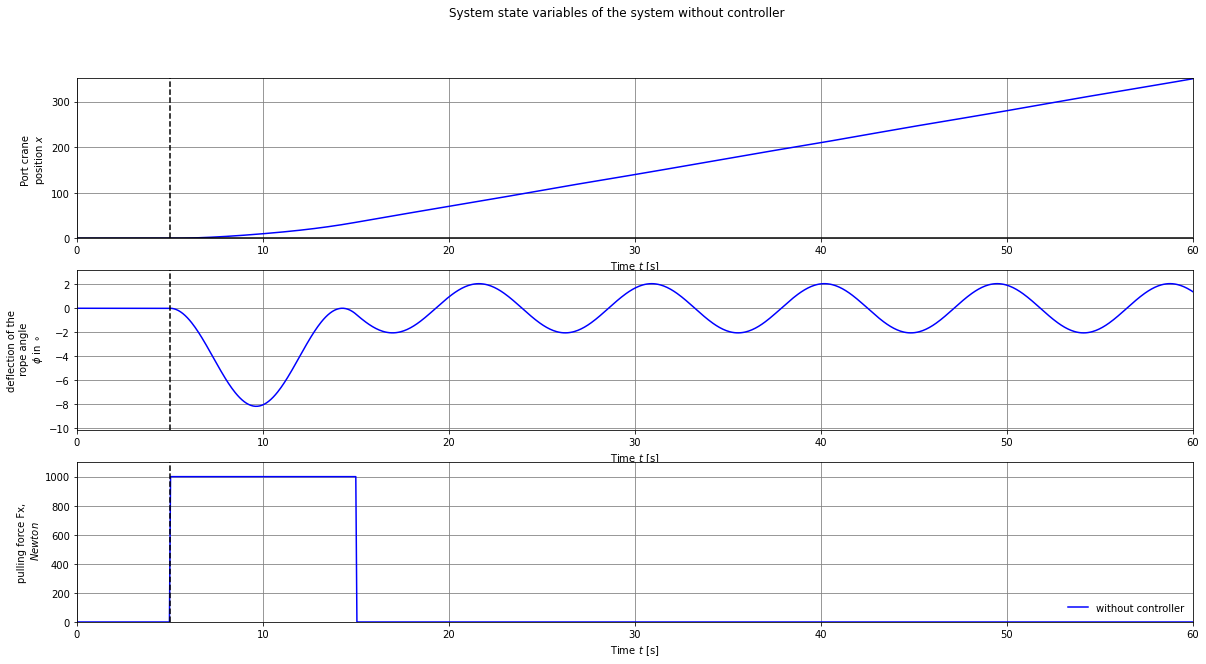

In [236]:
# Define the generator for simulating an aoutonomus object whithout
# controller, when state var equal to null. And also Fx = constant

# Define the time and input vectors
# Force starts from (time_start_force) sec and continue during  (time_application_of_force) sec of
# interval and than force become zero before the end of tine interval 
time_start_force=5
time_application_of_force = 10
time_interval_stop = 60 # length of time interval in sec 
T = np.linspace(0, time_interval_stop, 1000+1)
N_time_start_force = math.ceil((time_start_force/time_interval_stop)*(len(T)-1))
N_time_application_of_force = math.ceil((time_application_of_force/time_interval_stop)*(len(T)-1))
Fx = 1000*np.concatenate(( np.zeros(N_time_start_force),
            np.ones(N_time_application_of_force),
            np.zeros(len(T)-N_time_start_force-N_time_application_of_force) ))
#xref = 120*np.zeros(T.shape)
#phiref

# Find the eruilibrium point for the system
#Xeq, Phieq = ct.find_eqpt(
#    sys_object, [xref[0]]
#)

init_state_vars = [0,0,0,0] #[dx,ddx,dphi,ddphi]
# Response of the system with no integral feedback term
figsize=(20,10)
plt.figure(figsize=figsize)  
t, y_sfb = ct.input_output_response(sys_object, T, [Fx],init_state_vars)
subplots = system_dynamic_plot(sys_object, t, y_sfb, u=Fx,
         t_start_input=time_start_force, linetype='-b',fig_size=figsize)

# Add title and legend
plt.suptitle('System state variables of the system without controller')
import matplotlib.lines as mlines
pi_line = mlines.Line2D([], [], color='blue', linestyle='-', label='without controller')
plt.legend(handles=[pi_line], frameon=False, loc='lower right')

In [ ]:
def port_crane_outdcn(t ,x ,u , param={})
  # Get the port crane parameters that we need
  